In [1]:
#@title Imports
import sys
import re
import json

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
from transformers import TextDataset, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader

from accelerate import Accelerator
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Загружаю предобученную модель

checkpoint = "DeepPavlov/rudialogpt3_medium_based_on_gpt2_v2"   
tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [8]:
model.load_state_dict(torch.load('GPT2_checkpoint_all_data.pt')['model_state_dict'])

<All keys matched successfully>

In [3]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor
import lightning.pytorch as pl
import torch.nn as nn
from transformers import BertModel

# Тут я пытался реализовать через lightning, но постоянно Cuda out of memory, ничего не помогает

# class GPT(pl.LightningModule):
#     def __init__(self):
#         super().__init__()
        
#         self.gpt = AutoModelForCausalLM.from_pretrained(checkpoint)
#         self.automatic_optimization = False
        
#     def training_step(self, batch, batch_idx):
# #         outputs = self.gpt(**batch)
# #         loss = outputs.loss
# #         self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        
#         optimizer = self.optimizers()
#         optimizer.zero_grad()
#         outputs = self.gpt(**batch)
#         print(1)
#         loss = outputs.loss
#         print(2)
#         accelerator.backward(loss)
#         print(3)
#         optimizer.step()
        
#         self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        
#         return loss
        
# #     def validation_step(self, batch, batch_idx):
# #         outputs = self.gpt(batch)
# #         loss = outputs.loss
# #         self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    
#     def configure_optimizers(self):
#         optimizer = optim.Adam(self.parameters(), lr=1e-2)
        
# #         lr_scheduler = get_scheduler(
# #             "linear",
# #             optimizer=optimizer,
# #             num_warmup_steps=100,
# #             num_training_steps=num_training_steps
# #         )
        
#         return optimizer

# #     def forward(self, batch):
# #         outputs = self.gpt(**batch)
# #         return outputs

# # accelerator = Accelerator()
# # train_dl, test_dl, model, optimizer = accelerator.prepare(
# #     train_loader, test_loader, model, optimizer
# # )
    
    
# model = GPT()

In [5]:
# Разбиваю на трейн и тест и конструирую датасет

train_path, test_path = 'train_dataset.txt', 'test_dataset.txt'

train_dataset = TextDataset(tokenizer=tokenizer, file_path=train_path, block_size=128)
val_dataset = TextDataset(tokenizer=tokenizer, file_path=test_path, block_size=128)

/home/boris/anaconda3/lib/python3.9/site-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [6]:
# Это просто обертка в словарь
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

In [7]:
# Даталоадеры
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=12, collate_fn=data_collator)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, num_workers=12, collate_fn=data_collator)

In [8]:
# Оптимизатор, лернинг рейт невысокий для transfer learning-а, дообучаем же

optimizer = AdamW(model.parameters(), lr=3e-5)

num_training_steps = 5 * len(train_dataset)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)

accelerator = Accelerator()
train_dl, val_dl, model, optimizer = accelerator.prepare(
    train_loader, val_loader, model, optimizer
)

/home/boris/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
# from lightning.pytorch.callbacks import ModelCheckpoint
# from lightning.pytorch.loggers import TensorBoardLogger

# logger = TensorBoardLogger("tb_logs", name="dialogpt_1")
# checkpoint_callback = ModelCheckpoint(dirpath="models/", save_top_k=1, monitor="val_loss")

In [10]:
# import os
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [11]:
# import lightning.pytorch as pl

# trainer = pl.Trainer(max_epochs=1, callbacks=[checkpoint_callback], logger=logger)
# trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

In [12]:
# Шедулер и всякие параметры
num_epochs = 5
save_checkpoint_path = 'GPT2_checkpoint_all_data.pt' 


num_training_steps = num_epochs * len(train_dataset)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)

# Акселератор, кажется, не нужен. Я обучал на одной gpu и не использую accumulate.
accelerator = Accelerator()
train_dl, test_dl, model, optimizer = accelerator.prepare(
    train_loader, val_loader, model, optimizer
)
# wandb.watch(model, log="all")

In [13]:
model.cuda()
pass

In [15]:
from tqdm.notebook import tqdm

train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    
    # Обучение
    cum_loss = 0
    model.train()
    for batch in tqdm(train_dl):
        optimizer.zero_grad()
        # model(batch, labels=batch)
        outputs = model(**batch)
        loss = outputs.loss
        cum_loss += float(loss.item())
        accelerator.backward(loss)
        
        optimizer.step()
        lr_scheduler.step()

    train_losses.append(cum_loss / len(train_dl))

    torch.save({
            'model_state_dict': model.state_dict(),
    }, save_checkpoint_path)
    
    # Валидация
    cum_loss = 0
    model.eval()
    with torch.inference_mode():
        for batch in test_dl:
            outputs = model(**batch)
            cum_loss += float(outputs.loss.item())
    
    val_losses.append(cum_loss / len(test_dl))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/60143 [00:00<?, ?it/s]

  0%|          | 0/60143 [00:00<?, ?it/s]

  0%|          | 0/60143 [00:00<?, ?it/s]

  0%|          | 0/60143 [00:00<?, ?it/s]

  0%|          | 0/60143 [00:00<?, ?it/s]

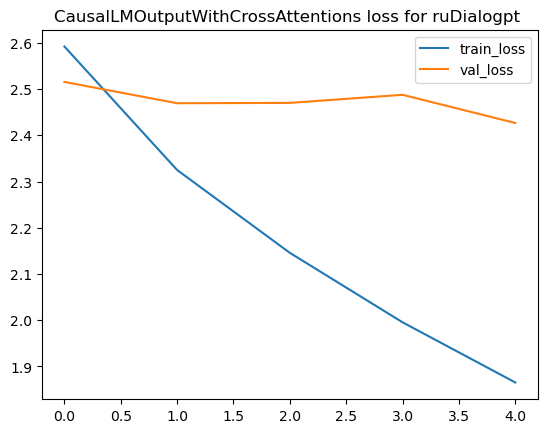

In [40]:
import matplotlib.pyplot as plt

plt.title('CausalLMOutputWithCrossAttentions loss for ruDialogpt ')

plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')

plt.legend()

In [29]:
train_losses

[2.592181996184225,
 2.3249960937242804,
 2.1458057207027594,
 1.9955618588847464,
 1.8654112551791995]

In [28]:
val_losses

[2.5154842698496873,
 2.4694369995333036,
 2.470156216893415,
 2.4876429400177895,
 2.426673198407938]

In [16]:
model = model.to('cpu')
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

In [33]:
# INFERENCE

chat_history_ids = torch.zeros((1, 0), dtype=torch.int)

while True:
    if True:
        # Добавляю входную строку в контекст
        input_text = "Расскажи анекдот про программиста"
        new_user_input_ids = tokenizer.encode(f"|0|1|" \
                                              + input_text + tokenizer.eos_token, return_tensors="pt")
        chat_history_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1)

    if True:
        # Добавляю флаг разделения
        new_user_input_ids = tokenizer.encode(f"|1|-|", return_tensors="pt")
        chat_history_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1)
                
        input_len = chat_history_ids.shape[-1]
        # Генерация ответа модели
        chat_history_ids = model.generate(
            chat_history_ids,
            num_return_sequences=1,                   
            max_length=512,
            no_repeat_ngram_size=3,
            do_sample=True,
            top_k=50,
            top_p=0.9,
            temperature = 0.5,                          
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )
        
        print(f"===> GPT-3:  {tokenizer.decode(chat_history_ids[0], skip_special_tokens=True)}")
        # Очищаю контекст
        chat_history_ids = torch.zeros((1, 0), dtype=torch.int)

===> GPT-3:  |0|1|Расскажи анекдот про программиста|1|-|"Если программист - это диагноз, то врач - это рецепт."|
===> GPT-3:  |0|1|Расскажи анекдот про программиста|1|-|"Программист - это тот, кто пишет программы для людей, которых не понимает ни один язык мира."|
===> GPT-3:  |0|1|Расскажи анекдот про программиста|1|-|"Программист - это человек, который пишет программы, не задумываясь о том, что он делает."|
===> GPT-3:  |0|1|Расскажи анекдот про программиста|1|-|"Программист - это единственный человек, который может сказать: 'Я знаю, как все устроено!'."|
===> GPT-3:  |0|1|Расскажи анекдот про программиста|1|-|"Объявление:
Программист ищет работу. Интим не предлагать."|
===> GPT-3:  |0|1|Расскажи анекдот про программиста|1|-|"Программист - это тот, кто пишет программы, которые пишут программы,
которые пишут программы."|
===> GPT-3:  |0|1|Расскажи анекдот про программиста|1|-|"'Sashok' а как называется программист, который работает 'по-программерски'?'Mihan' по-программист"|
===> GPT-

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:38                                                                                   │
│                                                                                                  │
│   35 │   │   # save previous len                                                                 │
│   36 │   │   input_len = chat_history_ids.shape[-1]                                              │
│   37 │   │   # generated a response; PS you can read about the parameters at hf.co/blog/how-t    │
│ ❱ 38 │   │   chat_history_ids = model.generate(                                                  │
│   39 │   │   │   chat_history_ids,                                                               │
│   40 │   │   │   num_return_sequences=1,                     # use for more variants, but hav    │
│   41 │   │   │   max_length=512,                                                                 │
│                                                                                                  │
│ /home/boris/.local/lib/python3.9/site-packages/torch/utils/_contextlib.py:115 in                 │
│ decorate_context                                                                                 │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /home/boris/anaconda3/lib/python3.9/site-packages/transformers/generation/utils.py:1565 in       │
│ generate                                                                                         │
│                                                                                                  │
│   1562 │   │   │   )                                                                             │
│   1563 │   │   │                                                                                 │
│   1564 │   │   │   # 13. run sample                                                              │
│ ❱ 1565 │   │   │   return self.sample(                                                           │
│   1566 │   │   │   │   input_ids,                                                                │
│   1567 │   │   │   │   logits_processor=logits_processor,                                        │
│   1568 │   │   │   │   logits_warper=logits_warper,                                              │
│                                                                                                  │
│ /home/boris/anaconda3/lib/python3.9/site-packages/transformers/generation/utils.py:2612 in       │
│ sample                                                                                           │
│                                                                                                  │
│   2609 │   │   │   model_inputs = self.prepare_inputs_for_generation(input_ids, **model_kwargs)  │
│   2610 │   │   │                                                                                 │
│   2611 │   │   │   # forward pass to get next token                                              │
│ ❱ 2612 │   │   │   outputs = self(                         